# Stance Detection Using Convolutional Neural Networks

`Convolutional Neural Networks`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on a very simple convolutional neural network to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```
The network we experiment with is inspired by the paper:
```
Convolutional Neural Networks for Sentence Classification.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

In [ ]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 40
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: بمناسبة العام الجديد  شركة ليكزس توزع 200 سيارة مجانا
Article text: كثيرا ما تداولت صحف ومواقع إخبارية تقارير عن الهدايا التي منحتها الملكة إليزابيث الثانية (  ) ملكة بريطانيا، للعاملين لديها بمناسبة أعياد الميلاد، إلا أن صور هذه الهدايا وطبيعتها لم تكشف بشكل كامل إلا مؤخرا، وتحديدا بعد أن كشف عنها أحد جامعي التذكارات الملكية، ويدعى إيان شابيرو ( )، ويمتلك إيان مجموعة من الهدايا الملكية التي قدمتها الملكة للعاملين لديها، وتتضمن وعاء أنيق من الكريستال وطاقم عبوات الملح والفلفل الخاصة بالمائدة وإطار صور أنيق يحمل صورة رسمية للملكة التقطت بمناسبة عيد ميلادها الثمانين. مجموعة هدايا الملكة للعاملين لديها منذ عام 2002 طبقا لما نشره موقع   فإن مجموعة الهدايا الملكية بمناسبة أعياد الميلاد والتي قام باقتنائها أيان شابيرو، تتضمن مجموعة من الهدايا الشخصية التي قدمتها الملكة لعدد من العاملين لديها في قصر باكنغهام وقلعة وندسور بمناسبة أعياد الميلاد خلال الفترة ما بين عامي 2002-2015، إلى جانب عدد من الهدايا التي اعتادت ملكة بريطانيا تقديمها لجميع العاملين لديها في كل عام مثل بودنج أعياد 

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [ ]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [ ]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [ ]:
instance_no = 40
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: بمناسبه العام الجديد شركه ليكزس توزع مئتان سياره مجانا كثيرا ما تداولت صحف ومواقع اخباريه تقارير عن الهدايا التي منحتها الملكه اليزابيث الثانيه ملكه بريطانيا للعاملين لديها بمناسبه اعياد الميلاد الا ان صور هذه الهدايا وطبيعتها لم تكشف بشكل كامل الا مؤخرا وتحديدا بعد ان كشف عنها احد جامعي التذكارات الملكيه ويدعي ايان شابيرو ويمتلك ايان مجموعه من الهدايا الملكيه التي قدمتها الملكه للعاملين لديها وتتضمن وعاء انيق من الكريستال وطاقم عبوات الملح والفلفل الخاصه بالمائده واطار صور انيق يحمل صوره رسميه للملكه التقطت بمناسبه عيد ميلادها الثمانين مجموعه هدايا الملكه للعاملين لديها منذ عام الفان و اثنان طبقا لما نشره موقع فان مجموعه الهدايا الملكيه بمناسبه اعياد الميلاد والتي قام باقتنائها ايان شابيرو تتضمن مجموعه من الهدايا الشخصيه التي قدمتها الملكه لعدد من العاملين لديها في قصر باكنغهام وقلعه وندسور بمناسبه اعياد الميلاد خلال الفتره ما بين عامي الفان و اثنان الفان و خمس عشره الي جانب عدد من الهدايا التي اعتادت ملكه بريطانيا تقديمها لجميع العاملين لديها في كل عام مثل بودنج ا

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

- Load the pretrained vectors:

In [ ]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [ ]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=30000, output_sequence_length=300, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29578 words (422 misses)


- Let's see the representation of a random token:

In [ ]:
print(f"The word 'مرحبا' is at index {word_index['مرحبا']}")
print(f"The vector representation of 'مرحبا' is {embedding_matrix[word_index['مرحبا']]}")

The word 'مرحبا' is at index 16121
The vector representation of 'مرحبا' is [-1.44302592e-01 -6.39321446e-01  4.45061564e-01  6.10517323e-01
 -1.06314147e+00 -2.28464055e+00 -2.12285829e+00  1.31066144e+00
  9.45485756e-02 -1.37774479e+00 -7.44283319e-01 -1.13222992e+00
  2.30274630e+00 -6.58436835e-01 -7.23377109e-01  1.35918117e+00
 -9.82603788e-01 -1.10084295e+00  1.32851040e+00 -1.28662968e+00
 -5.39303184e-01  1.37298048e+00  9.84080493e-01 -1.65784693e+00
 -4.53935623e-01 -6.18479252e-01  2.29252517e-01  7.04917073e-01
  1.89954668e-01 -1.51370668e+00  5.11061490e-01  1.86038971e+00
 -9.81792033e-01  1.64159513e+00 -3.68691802e-01 -1.79303563e+00
  1.14815608e-01 -2.72244662e-01  1.08685076e+00  5.84681988e-01
  6.44134104e-01  1.79219103e+00  1.51250648e+00 -5.59856296e-01
 -3.20600648e-03 -7.41101503e-01 -4.27743375e-01 -1.51901293e+00
 -8.97554934e-01  1.64167547e+00  2.09141355e-02  1.25073385e+00
  2.20205307e+00 -9.57377374e-01 -8.43060791e-01 -1.92027688e-01
 -1.69827435e-0

- Let's initialize our embedding layer with the embedding matrix:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [ ]:
batch_size = 64

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [ ]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [ ]:
instance_no = 40
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: بمناسبه العام الجديد شركه ليكزس توزع مئتان سياره مجانا كثيرا ما تداولت صحف ومواقع اخباريه تقارير عن الهدايا التي منحتها الملكه اليزابيث الثانيه ملكه بريطانيا للعاملين لديها بمناسبه اعياد الميلاد الا ان صور هذه الهدايا وطبيعتها لم تكشف بشكل كامل الا مؤخرا وتحديدا بعد ان كشف عنها احد جامعي التذكارات الملكيه ويدعي ايان شابيرو ويمتلك ايان مجموعه من الهدايا الملكيه التي قدمتها الملكه للعاملين لديها وتتضمن وعاء انيق من الكريستال وطاقم عبوات الملح والفلفل الخاصه بالمائده واطار صور انيق يحمل صوره رسميه للملكه التقطت بمناسبه عيد ميلادها الثمانين مجموعه هدايا الملكه للعاملين لديها منذ عام الفان و اثنان طبقا لما نشره موقع فان مجموعه الهدايا الملكيه بمناسبه اعياد الميلاد والتي قام باقتنائها ايان شابيرو تتضمن مجموعه من الهدايا الشخصيه التي قدمتها الملكه لعدد من العاملين لديها في قصر باكنغهام وقلعه وندسور بمناسبه اعياد الميلاد خلال الفتره ما بين عامي الفان و اثنان الفان و خمس عشره الي جانب عدد من الهدايا التي اعتادت ملكه بريطانيا تقديمها لجميع العاملين لديها في كل عام

- Let's initialize the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
lr = 6e-4
epochs = 100
drop_rate = 0.3

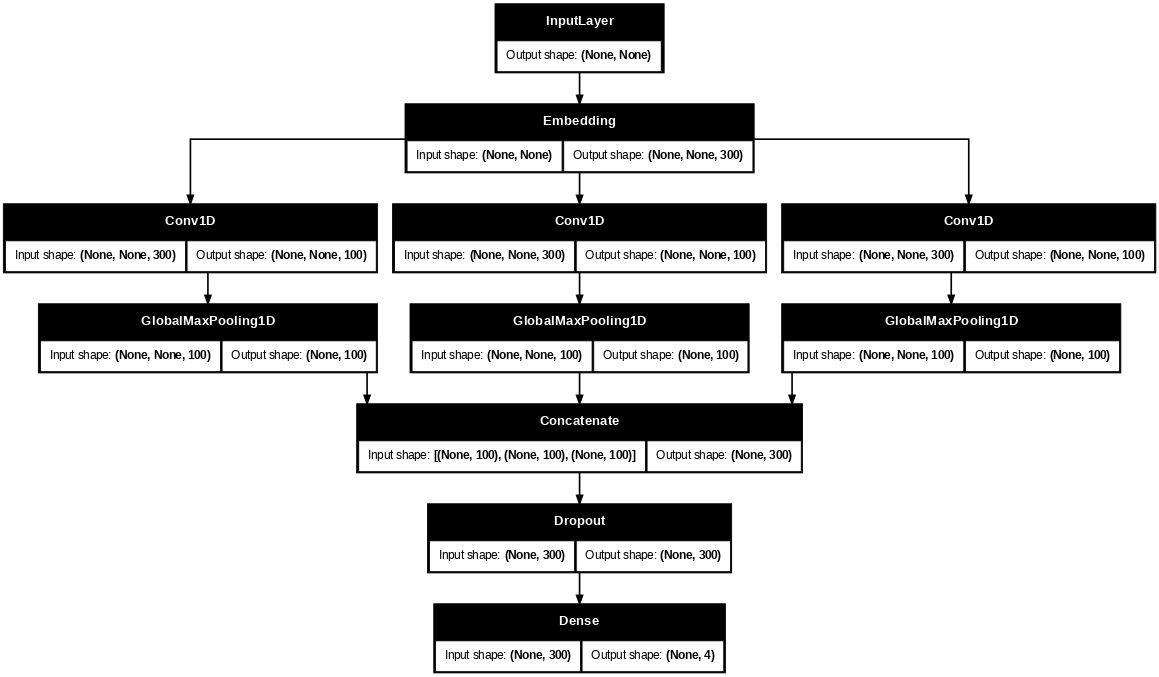

In [ ]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
conv1 = tf.keras.layers.Conv1D(100, 2, activation="relu", use_bias=True)(embedded_sequences)
conv2 = tf.keras.layers.Conv1D(100, 3, activation="relu", use_bias=True)(embedded_sequences)
conv3 = tf.keras.layers.Conv1D(100, 4, activation="relu", use_bias=True)(embedded_sequences)

pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
pool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

concatenated = tf.keras.layers.Concatenate(axis=1)([pool1, pool2, pool3])

dropped = tf.keras.layers.Dropout(drop_rate)(concatenated)

logits = tf.keras.layers.Dense(4)(dropped)

model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [ ]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      9,000,600 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_63 (Conv1D)        │ (None, None, 100)      │         60,100 │ embedding[21][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_64 (Conv1D)        │ (None, None, 100)      │         90,100 │ embedding[21][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_65 (Conv1D)        │ (None, None, 100)      │        120,100 │ embedding[21][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_63   │ (None, 100)            │              0 │ conv1d_63[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_64   │ (None, 100)            │              0 │ conv1d_64[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_65   │ (None, 100)            │              0 │ conv1d_65[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21            │ (None, 300)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 300)            │              0 │ concatenate_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 4)              │          1,204 │ dropout_21[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,815,114 (37.44 MB)

 Trainable params: 271,504 (1.04 MB)

 Non-trainable params: 9,000,600 (34.33 MB)

 Optimizer params: 543,010 (2.07 MB)

## Training

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
history=model.fit(
  x=train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3966 - loss: 5.2055 - val_accuracy: 0.5712 - val_loss: 2.0527
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5523 - loss: 2.8676 - val_accuracy: 0.6221 - val_loss: 1.6644
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6501 - loss: 1.8534 - val_accuracy: 0.7100 - val_loss: 1.2902
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6921 - loss: 1.3779 - val_accuracy: 0.6837 - val_loss: 1.4639
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7459 - loss: 1.1474 - val_accuracy: 0.7100 - val_loss: 1.5184
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7747 - loss: 1.0629 - val_accuracy: 0.7399 - val_loss: 1.2883
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7935 - loss: 0.8439 - val_accuracy: 0.7610 - val_loss: 1.2241
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8026 - loss: 0.7790 - val_accuracy: 0.

- Plot learning curves:

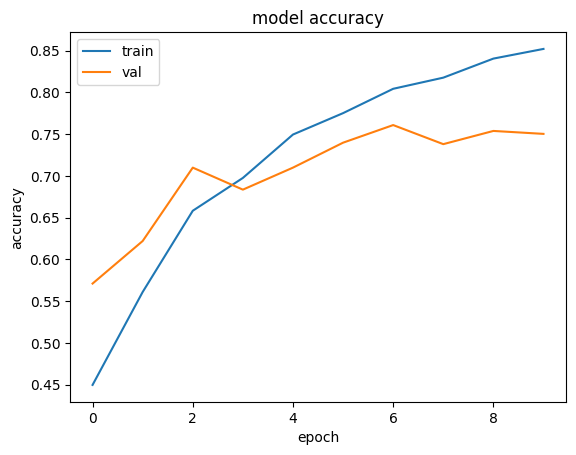

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

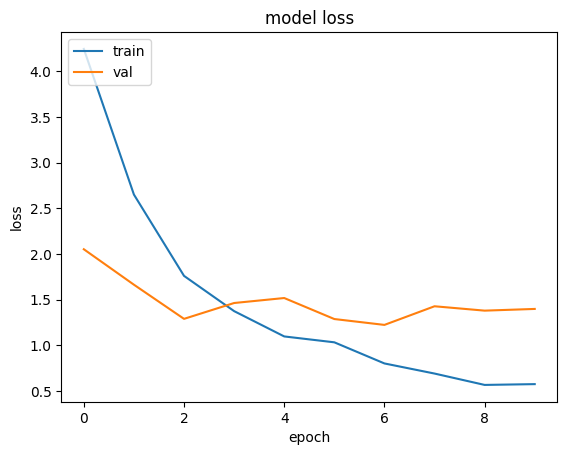

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7610 - loss: 1.4233
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Loss                       : 1.3989309072494507
Accuracy                   : 0.7504393673110721
F1 score                   : [0.67592593 0.71111111 0.46938776 0.82148041]
Macro F1 score             : 0.6694762996312862


In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8544 - loss: 0.8601
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Loss                       : 1.089264154434204
Accuracy                   : 0.8126934984520123
F1 score                   : [0.81428571 0.69642857 0.42105263 0.87453416]
Macro F1 score             : 0.701575269695979


- Let's see the confusion matrix on the testing dataset:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


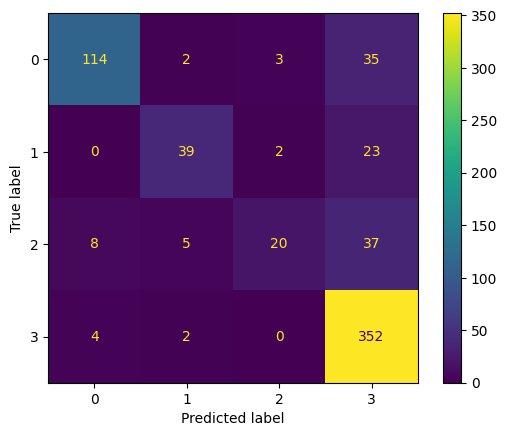

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

- Most of the mistakes the model does are on instances from the 'agree', 'disagree', and 'discuss' classes missclassified as 'unrelated':
  - This suggests that the majority 'unrelated' class is dominating the learning process.
  - This calls for a measure to balance the dataset, like undersampling, oversampling, and data augmentation.

## A word on overfitting

- Needs further investigation (next step).
- In [A first thought on overfitting](https://github.com/Ali-Mhrez/Stance-Detection/blob/main/SD_MLP.ipynb), we argue that the performance on the validation set stopped improving due to limits in the dataset, thus it is not clear how much we should attribute the learning curves to overfitting versus model struggling to capture the underlying concepts of the 'disagree' and 'discuss' classes.